In [3]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 106.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [5]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU found!")
    !nvidia-smi
else:
    print("GPU not found")

2025-04-30 14:49:41.657875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746024581.901131      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746024581.980316      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU found!
Wed Apr 30 14:49:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------------

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as ks
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                    Dropout, BatchNormalization, GlobalAveragePooling2D,
                                    Reshape, Layer, Input)
from tensorflow.keras.applications import ResNet50, EfficientNetB3 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ReduceLROnPlateau, EarlyStopping,
                                      TensorBoard, ModelCheckpoint)
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, RocCurveDisplay,classification_report, accuracy_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras import backend as K
from sklearn.utils import resample
import joblib

In [7]:
import sklearn
print(sklearn.__version__)
print(tf.__version__)
print(ks.__version__)
print(np.__version__)

1.6.1
2.18.0
3.5.0
1.26.4


In [8]:
# Load dataset
BASE_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/'
metadata = pd.read_csv(BASE_PATH + 'HAM10000_metadata.csv')

print(f"Dataset shape: {metadata.shape[0]} rows × {metadata.shape[1]} columns")
print("Columns:", metadata.columns.tolist())

Dataset shape: 10015 rows × 7 columns
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


In [9]:
image_dir_1 = BASE_PATH + 'HAM10000_images_part_1/'
image_dir_2 = BASE_PATH + 'HAM10000_images_part_2/'

image_dir_1 and image_dir_2 now hold the full paths to the two folders of JPEG images.
Later you’ll check both directories to find each image file by its image_id.

In [10]:
# Create a dictionary to map each image_id to its correct path
image_paths = {}
for img_id in metadata['image_id']:
    img_filename = img_id + '.jpg'
    if os.path.exists(image_dir_1 + img_filename):
        image_paths[img_id] = image_dir_1 + img_filename
    elif os.path.exists(image_dir_2 + img_filename):
        image_paths[img_id] = image_dir_2 + img_filename
    else:
        image_paths[img_id] = np.nan

# Now apply it to your metadata and re-split
metadata['path'] = metadata['image_id'].map(image_paths)


Loop: for every image_id in your metadata.

Check: first look in HAM10000_images_part_1/, then in …_part_2/.

Map: save the full path if found; otherwise assign NaN for missing files.

In [11]:
# Apply the mapping
metadata['path'] = metadata['image_id'].map(image_paths)

.map(image_paths): replaces each image_id with its corresponding file path (or NaN if missing).

Result: metadata now has a path column you can feed directly into your data generators to load the images.

In [12]:
metadata = metadata.dropna(subset=['path']).reset_index(drop=True)


Dropping any rows where the path is NaN (i.e., no image file was found).

Resetting the index so that row numbers run sequentially from 0 again.

In [13]:
metadata['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

It returns a Series listing each unique dx value (e.g. “nv”, “mel”, “bkl”, etc.) along with its count.

This lets you see the class imbalance in the raw dataset before any remapping or resampling.

In [15]:
# Map to 4 classes: 3 cancer types and 1 "Not Cancer"
def map_to_4class(label):
    notcancer = 'not_cancer'
    if label == 'akiec':
        return label  # Actinic Keratoses
    elif label == 'bcc':
        return label  # Basal Cell Carcinoma
    elif label == 'mel':
        return label  # Melanoma
    else:
        return notcancer  # Not Cancer (nv, bkl, vasc, df)

# Apply mapping
metadata['label_4class'] = metadata['dx'].apply(map_to_4class)

# Print distributions to show the difference
print("Original (7-class) distribution:\n", metadata['dx'].value_counts(), "\n")
print("Mapped (4-class) distribution:\n", metadata['label_4class'].value_counts())

Original (7-class) distribution:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64 

Mapped (4-class) distribution:
 label_4class
not_cancer    8061
mel           1113
bcc            514
akiec          327
Name: count, dtype: int64


The raw dx column has seven values:
* akiec (Actinic Keratoses)
* bcc (Basal Cell Carcinoma)
* mel (Melanoma)
* nv (Melanocytic Nevus)
* bkl (Benign Keratosis-like Lesions)
* vasc (Vascular Lesions)
* df (Dermatofibroma)
  
To simplify the task, we “pull out” the three cancer types of special interest (akiec, bcc, mel) and lump everything else into one “not_cancer” bucket.

You feed in each original diagnosis string (label).
If it’s akiec, bcc, or mel, you return it unchanged.
Otherwise (for nv, bkl, vasc, df), you return "not_cancer".

In [16]:
# 1. Original 7-class counts
orig_counts = metadata['dx'].value_counts().rename_axis('dx').reset_index(name='count')
orig_counts['label_4class'] = orig_counts['dx'].apply(map_to_4class)

# 2. Summarize into 4 classes
mapped_counts = orig_counts.groupby('label_4class')['count'].sum().reset_index()

# 3. Display both tables
print("Original (7 classes):")
print(orig_counts)
print("\nMapped (4 classes):")
print(mapped_counts)


Original (7 classes):
      dx  count label_4class
0     nv   6705   not_cancer
1    mel   1113          mel
2    bkl   1099   not_cancer
3    bcc    514          bcc
4  akiec    327        akiec
5   vasc    142   not_cancer
6     df    115   not_cancer

Mapped (4 classes):
  label_4class  count
0        akiec    327
1          bcc    514
2          mel   1113
3   not_cancer   8061


orig_counts collects each of the 7 original labels and how many times it appears.

We then apply your same map_to_4class function to that table, giving each row its new 4-class label.

mapped_counts groups by the new 4-class label and sums up all the original counts that fell into each bucket.

In [17]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label_4class
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,not_cancer
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,not_cancer
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,not_cancer
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,not_cancer
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,not_cancer
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec


In [18]:
metadata['label_4class'].value_counts()

label_4class
not_cancer    8061
mel           1113
bcc            514
akiec          327
Name: count, dtype: int64

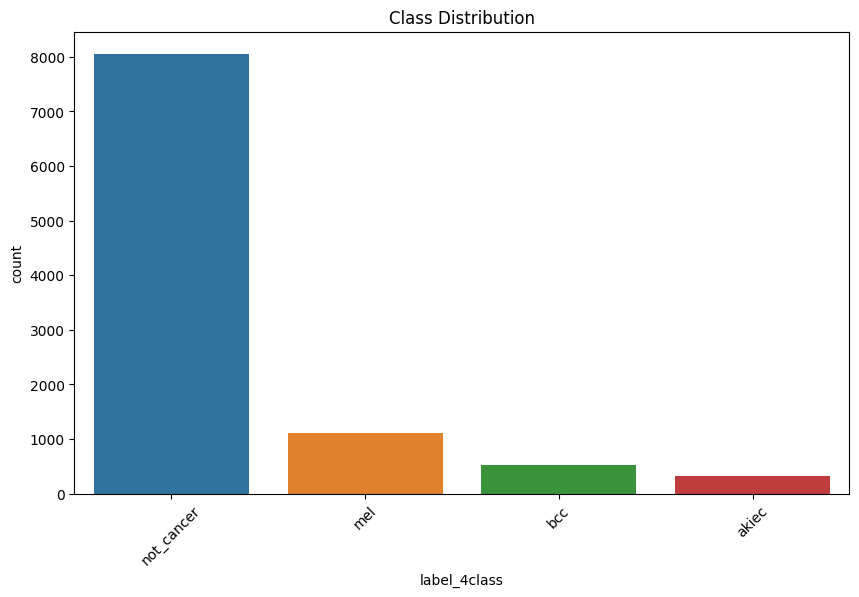

In [19]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='label_4class', order=metadata['label_4class'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_31/4050029317.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_images = metadata.groupby('label_4class').apply(lambda x: x.sample(1)).reset_index(drop=True)


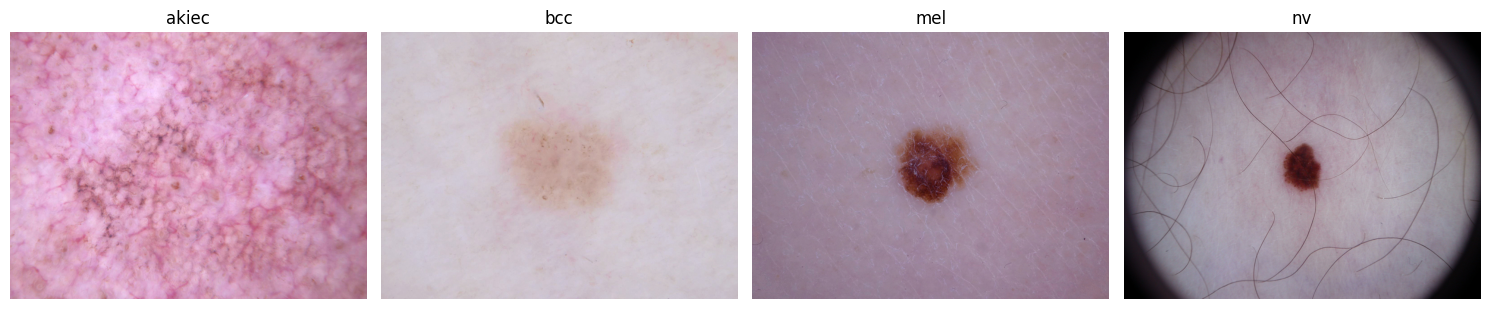

In [20]:
# Display sample images
plt.figure(figsize=(15, 10))
sample_images = metadata.groupby('label_4class').apply(lambda x: x.sample(1)).reset_index(drop=True)
for idx, row in enumerate(sample_images.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot(2, 4, idx)
    plt.imshow(img)
    plt.title(f"{row.dx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Resample to 3000 samples per class
resampled_df = []
for label in metadata['label_4class'].unique():
    class_subset = metadata[metadata['label_4class'] == label]
    resampled_subset = resample(class_subset,
                                replace=True,
                                n_samples=3000,
                                random_state=42)
    resampled_df.append(resampled_subset)

Purpose: each class regardless of its original size—will contribute exactly 3,000 samples to your final training pool, preventing the model from being biased toward over-represented classes.

In [22]:
metadata = pd.concat(resampled_df).reset_index(drop=True)

pd.concat(resampled_df) merges the list of DataFrames (resampled_df) each containing exactly 3,000 rows for one class—into a single DataFrame with 12,000 rows total.

.reset_index(drop=True) throws away the old row indices (which would overlap across the subsets) and assigns new sequential indices from 0 to 11,999.

/tmp/ipykernel_31/4050029317.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_images = metadata.groupby('label_4class').apply(lambda x: x.sample(1)).reset_index(drop=True)


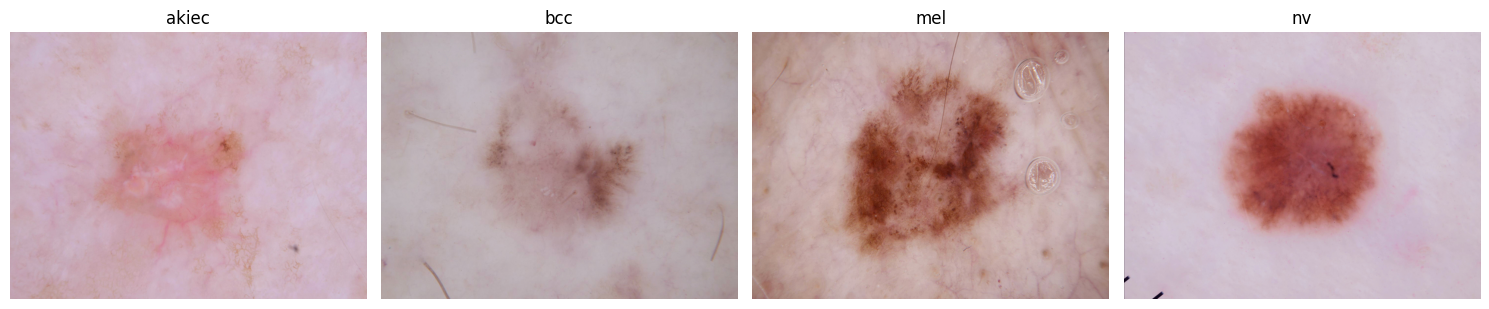

In [23]:
# Display sample images
plt.figure(figsize=(15, 10))
sample_images = metadata.groupby('label_4class').apply(lambda x: x.sample(1)).reset_index(drop=True)
for idx, row in enumerate(sample_images.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot(2, 4, idx)
    plt.imshow(img)
    plt.title(f"{row.dx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Verify new distribution
print(metadata['label_4class'].value_counts())

label_4class
not_cancer    3000
mel           3000
bcc           3000
akiec         3000
Name: count, dtype: int64


In [25]:
# Split into train (70%), validation (15%), and test (15%)
train_df, test_df = train_test_split(metadata, test_size=0.15, stratify=metadata['label_4class'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df['label_4class'], random_state=42)  # 0.1765 x 0.85 ≈ 0.15

In [26]:
f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}"

'Train size: 8399, Val size: 1801, Test size: 1800'

In [27]:
train_df['label_4class'].value_counts()

label_4class
not_cancer    2100
bcc           2100
akiec         2100
mel           2099
Name: count, dtype: int64

In [28]:
test_df['label_4class'].value_counts()

label_4class
bcc           450
not_cancer    450
akiec         450
mel           450
Name: count, dtype: int64

In [29]:
val_df['label_4class'].value_counts()

label_4class
mel           451
akiec         450
bcc           450
not_cancer    450
Name: count, dtype: int64

In [30]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,           # Reduce to 10-15 degrees
    width_shift_range=0.05,      # ~5% shift
    height_shift_range=0.05,
    zoom_range=0.1,              # ~10% zoom
    shear_range=0.05,            # Minimal shearing
    horizontal_flip=True,
    fill_mode='nearest'
)

In [31]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

rescale=1./255 means every pixel value (originally in [0,255]) will be divided by 255, bringing it into the [0,1] range.

Unlike the training generator, they do not apply any random augmentations (rotations, shifts, flips, etc.).

You’ll use these with .flow_from_dataframe(...) so that your model sees normalized images on validation/tests, matching the scale it was trained on.

In [32]:
# Data Generators
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label_4class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

In [33]:
print(train_df.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'label_4class'],
      dtype='object')


In [34]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label_4class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 8399 validated image filenames belonging to 4 classes.


Images are too large to fit into memory at once → we load batches instead.

We automatically augment the images while loading (rotation, shift, zoom, etc.).

It keeps everything efficient and memory-friendly.

Helps the model see more variations and generalize better.

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for validation (usually no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label_4class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1801 validated image filenames belonging to 4 classes.


In training: shuffle=True helps the model learn better (more random).

In validation: shuffle=False is needed because you compare prediction vs true label directly.

If you shuffle during validation, your loss and accuracy measurements become wrong!



In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data generator
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label_4class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1800 validated image filenames belonging to 4 classes.


In [37]:
# Data Verification
# Check image normalization
sample_images, sample_labels = next(train_generator)
print("Image batch shape:", sample_images.shape)
print("Pixel range:", sample_images.min(), "-", sample_images.max())  # Should be 0-1

Image batch shape: (32, 224, 224, 3)
Pixel range: 0.0 - 0.9999993


32 images in this batch (because BATCH_SIZE=32).

Each image is resized to 224 × 224 pixels.

Each image has 3 color channels (RGB).

Pixel values are normalized between 0 and 1.

Originally, pixel values are 0–255, but you divided by 255 during ImageDataGenerator(rescale=1./255) to make it easier for the model to learn.

In [38]:
# Verify class mapping
print("Class indices:", train_generator.class_indices)
print("Sample labels (one-hot):", sample_labels[:2])

Class indices: {'akiec': 0, 'bcc': 1, 'mel': 2, 'not_cancer': 3}
Sample labels (one-hot): [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]


'akiec' is class 0

'bcc' is class 1

'mel' is class 2

'not_cancer' is class 3

First image belongs to class index 3 → 'not_cancer'

Second image belongs to class index 2 → 'mel'

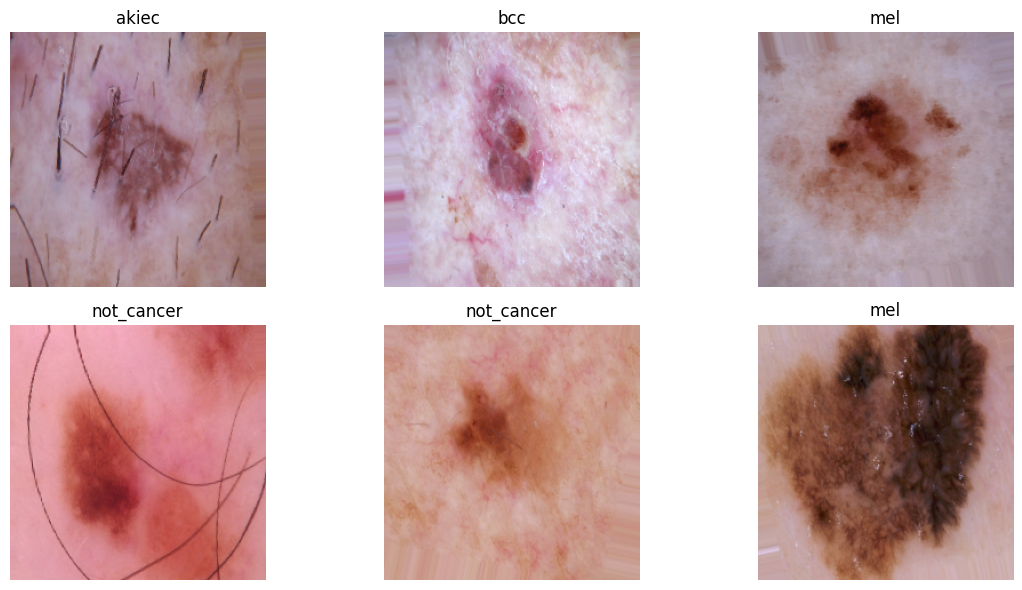

In [39]:
# Visualize samples
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_images[i])
    plt.title(list(train_generator.class_indices.keys())[np.argmax(sample_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
# Convert dict_keys to a list
class_labels = list(train_generator.class_indices.keys())

print(class_labels)

['akiec', 'bcc', 'mel', 'not_cancer']


Later, when you plot or predict, you will want to display the class names, not the numbers (0, 1, 2, 3).

So we save the class names into class_labels for easy use.



In [41]:
# Get the unique class labels from the training data
unique_classes = np.unique(train_generator.classes)

print(unique_classes)

[0 1 2 3]


In [42]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_generator.classes
)

In [43]:
# Correct dictionary creation
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

enumerate(class_weights) gives you both the index and the weight

In [44]:
# To verify weights
class_weight_dict

{0: 0.9998809523809524,
 1: 0.9998809523809524,
 2: 1.0003573130061933,
 3: 0.9998809523809524}

In [45]:
aug_iter = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label_4class',
    target_size=(224, 224),
    batch_size=1,  # One image at a time for visualization
    class_mode='categorical',
    shuffle=True
)

Found 8399 validated image filenames belonging to 4 classes.


This creates a special data generator called aug_iter.

It loads and applies data augmentation (rotations, flips, zoom, etc.) on images on the fly.

Important settings:

batch_size=1: Load only one image at a time — makes it easy to visualize each augmented image individually.

shuffle=True: Randomly picks images — you won't get images in order (more realistic for training).

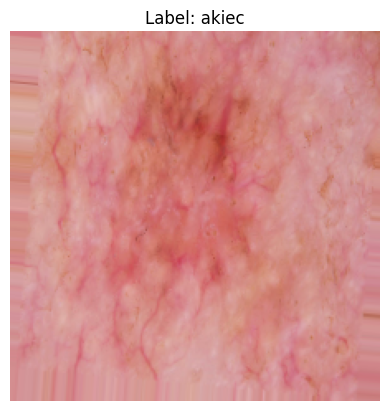

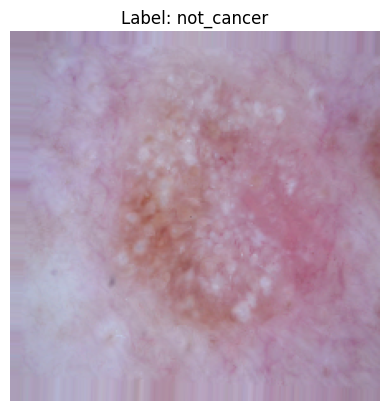

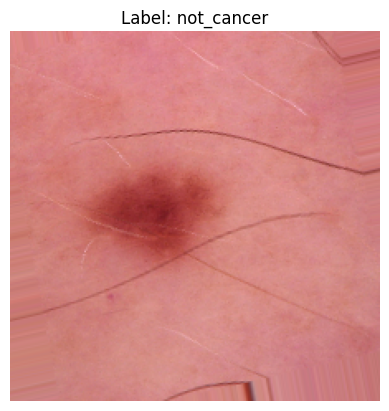

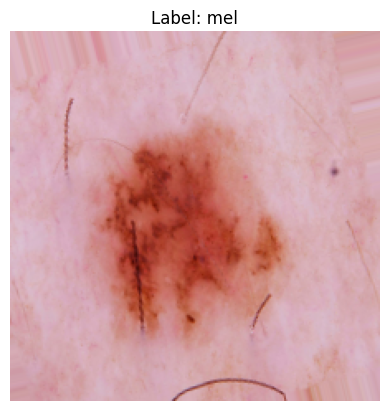

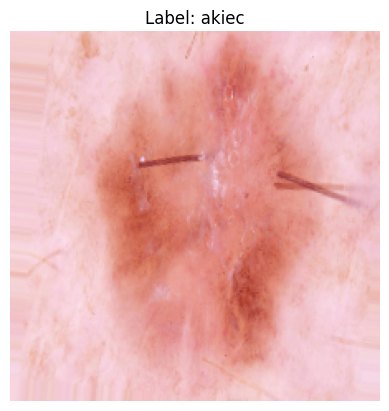

In [46]:
# Mapping class index back to label
class_indices = aug_iter.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

for _ in range(5):
    image_batch, label_batch = next(aug_iter)
    image = image_batch[0]
    label_idx = np.argmax(label_batch[0])
    label_name = inv_class_indices[label_idx]

    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis('off')
    plt.show()

This code visualizes 5 random augmented images and displays their correct labels on top.

In [47]:
# Callbacks
def get_callbacks(model_name):
    # Create a directory to save the models
    save_dir = 'saved_models'
    os.makedirs(save_dir, exist_ok=True)  # Create if it doesn't exist

    # Set the filepath based on the model name
    if model_name == 'cnn':
        filepath = os.path.join(save_dir, 'best_cnn_model.keras') 
    elif model_name == 'resnet':
        filepath = os.path.join(save_dir, 'best_resnet_model.keras')
    elif model_name == "resnet_finetuned":
        filepath = os.path.join(save_dir, "best_resnet_finetuned.keras")
    elif model_name == "effnet":
        filepath = os.path.join(save_dir, 'best_effnet_model.keras')
    elif model_name == "effnet_finetuned":
        filepath = os.path.join(save_dir, 'best_effnet_finetuned.keras')
    else:
        filepath = os.path.join(save_dir, 'best_model.keras') 

    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-6  
        ),
        ModelCheckpoint(
            filepath,  
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

Early stopping (stop training if it’s not improving),

Save the best model (checkpoint),

Reduce the learning rate if the model gets stuck

EarlyStopping:

Watches validation accuracy (val_accuracy).

If it doesn’t improve for 10 epochs, it stops training early.

And it restores the best weights found during training.

ReduceLROnPlateau:

Watches validation loss (val_loss).

If the loss doesn’t improve for 3 epochs, it reduces learning rate by 50%.

This helps the model escape "plateaus" where loss is stuck.

ModelCheckpoint:

Saves the best model automatically when validation accuracy improves.

Only the best model is kept (save_best_only=True).



In [48]:
cnn_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 4 (deeper block for better performance)
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Dense Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
print("done")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746024876.989116      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


done


In [56]:
# Compile CNN Model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [ ]:
cnn_model.summary()

Total params	9,828,804 → All weights and biases in your model.

Trainable params	9,827,844 → Parameters that the model will update during training.

Non-trainable params	960 → Parameters that are fixed, not updated during training (like inside BatchNormalization layers sometimes).

In [49]:
# Verify first batch predictions
# Initial predictions (should be ~0.25 per class)
print(cnn_model.predict(sample_images[:1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.25376776 0.21880092 0.26022857 0.2672027 ]]


In [49]:
# Compile the model
# cnn_model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',  # or 'binary_crossentropy' for binary classification
#     metrics=['accuracy']
# )
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Training CNN Model
print("Training CNN Model...")
cnn_history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks('cnn'),
    class_weight=class_weight_dict
)


Training CNN Model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746024902.772632      85 service.cc:148] XLA service 0x7a1ca8015b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746024902.773708      85 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746024903.375812      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/263 ━━━━━━━━━━━━━━━━━━━━ 1:18:28 18s/step - accuracy: 0.2188 - auc: 0.4559 - loss: 4.0556

I0000 00:00:1746024909.513411      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5252 - auc: 0.7707 - loss: 2.4946
Epoch 1: val_accuracy improved from -inf to 0.25819, saving model to saved_models/best_cnn_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 195s 675ms/step - accuracy: 0.5256 - auc: 0.7711 - loss: 2.4910 - val_accuracy: 0.2582 - val_auc: 0.5360 - val_loss: 5.4216 - learning_rate: 1.0000e-04
Epoch 2/50
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6414 - auc: 0.8672 - loss: 1.6994
Epoch 2: val_accuracy improved from 0.25819 to 0.57635, saving model to saved_models/best_cnn_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 139s 516ms/step - accuracy: 0.6414 - auc: 0.8672 - loss: 1.6993 - val_accuracy: 0.5763 - val_auc: 0.8349 - val_loss: 1.9287 - learning_rate: 1.0000e-04
Epoch 3/50
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6721 - auc: 0.8908 - loss: 1.5966
Epoch 3: val_accuracy improved from 0.57635 to 0.72016, saving model to saved_models/best_cnn_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━

In [50]:
# Predictions from the model
y_pred = cnn_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print("done")

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step
done


In [51]:
# True labels from the generator
y_true = val_generator.classes

In [52]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

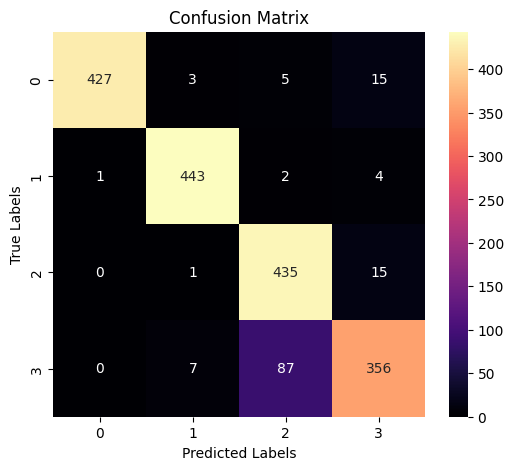

In [53]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9977    0.9489    0.9727       450
           1     0.9758    0.9844    0.9801       450
           2     0.8223    0.9645    0.8878       451
           3     0.9128    0.7911    0.8476       450

    accuracy                         0.9223      1801
   macro avg     0.9271    0.9222    0.9220      1801
weighted avg     0.9271    0.9223    0.9220      1801



In [55]:
results = cnn_model.evaluate(test_generator)
for name, value in zip(cnn_model.metrics_names, results):
    print(f'{name}: {value:.4f}')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9264 - auc: 0.9917 - loss: 0.6034
loss: 0.6057
compile_metrics: 0.9261


In [1]:
from tensorflow.keras.applications import ResNet50


2025-04-30 21:19:59.979840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746048000.149711      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746048000.202367      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inputs = Input(shape=(224, 224, 3))
x = base_resnet(inputs, training=False)  # Freeze ResNet
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x) 
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x) 
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

I0000 00:00:1746048018.812729      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


NameError: name 'Input' is not defined

In [59]:
resnet_model = Model(inputs, outputs)

In [61]:
resnet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

In [62]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,692 (92.11 MB)

 Trainable params: 24,093,060 (91.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [63]:
# Training Resnet Model
print("Training ResNet Model...")
resnet_history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=get_callbacks('resnet'),
    class_weight=class_weight_dict
)

Training ResNet Model...
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5766 - auc: 0.8064 - loss: 1.8258
Epoch 1: val_accuracy improved from -inf to 0.25042, saving model to saved_models/best_resnet_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 253s 660ms/step - accuracy: 0.5770 - auc: 0.8067 - loss: 1.8246 - val_accuracy: 0.2504 - val_auc: 0.5047 - val_loss: 3.8420 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8151 - auc: 0.9578 - loss: 1.1172
Epoch 2: val_accuracy did not improve from 0.25042
263/263 ━━━━━━━━━━━━━━━━━━━━ 153s 570ms/step - accuracy: 0.8152 - auc: 0.9578 - loss: 1.1171 - val_accuracy: 0.2499 - val_auc: 0.4894 - val_loss: 6.6255 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8676 - auc: 0.9764 - loss: 0.9678
Epoch 3: val_accuracy did not improve from 0.25042
263/263 ━━━━━━━━━━━━━━━━━━━━ 148s 549ms/step - accuracy: 0.8676 - auc: 0.9764 - loss: 0.9677 - val_

In [64]:
# Fine-tuning (Unfreeze some layers)
print("Fine-tuning ResNet...")
base_resnet.trainable = True
for layer in base_resnet.layers[:-20]:  # Unfreeze last 20 layers
    layer.trainable = False

Fine-tuning ResNet...


In [65]:
# Debug: Print number of trainable layers
trainable_count = sum([1 for layer in base_resnet.layers if layer.trainable])
print(f"Fine-tuning ResNet: {trainable_count} layers are now trainable.")







Fine-tuning ResNet: 20 layers are now trainable.


In [66]:
# Recompile with lower learning rate
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [67]:
resnet_finetune_history = resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=get_callbacks('resnet_finetuned'),
    class_weight=class_weight_dict
)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.3354
Epoch 1: val_accuracy improved from -inf to 0.95780, saving model to saved_models/best_resnet_finetuned.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 172s 558ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.3354 - val_accuracy: 0.9578 - val_auc: 0.9875 - val_loss: 0.5157 - learning_rate: 1.0000e-05
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.3142
Epoch 2: val_accuracy did not improve from 0.95780
263/263 ━━━━━━━━━━━━━━━━━━━━ 133s 495ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.3142 - val_accuracy: 0.9545 - val_auc: 0.9875 - val_loss: 0.5107 - learning_rate: 1.0000e-05
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.2978
Epoch 3: val_accuracy did not improve from 0.95780
263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 497ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.2978 - val_accuracy: 0.9578 - va

In [2]:
# Predictions from the model
y_pred = resnet_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

NameError: name 'resnet_model' is not defined

In [3]:
# True labels from the generator
y_true = val_generator.classes

NameError: name 'val_generator' is not defined

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))

In [ ]:
resnet_test_loss, resnet_test_acc, resnet_test_auc = resnet_model.evaluate(test_generator)
print(f'ResNet Test Accuracy: {resnet_test_acc:.4f}, AUC: {resnet_test_auc:.4f}')

In [ ]:
# Evaluate DL Models
def plot_model_evaluation(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o', linestyle='dashed')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='dashed')
    plt.title(f'{model_name} Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_model_evaluation(cnn_history, 'CNN')
plot_model_evaluation(resnet_history, 'ResNet50 - Frozen')
plot_model_evaluation(resnet_finetune_history, 'ResNet50 - Fine-Tuned')

In [ ]:
def evaluate_model(model, generator, model_name):
    print(f"\nEvaluating {model_name}...")
    results = model.evaluate(generator)
    print(f"Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, AUC: {results[2]:.4f}")

    # Predictions
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC AUC (OvR)
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
    roc_auc = roc_auc_score(y_true_bin, y_pred, multi_class='ovr')
    print(f"ROC AUC (OvR): {roc_auc:.4f}")

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(class_labels)):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred[:, i],
            name=f"{class_labels[i]} vs Rest",
        )
    plt.title(f'ROC Curves - {model_name}')
    plt.show()

In [ ]:
evaluate_model(cnn_model, test_generator, "Custom CNN")
evaluate_model(resnet_model, test_generator, "Fine-tuned ResNet50")

In [ ]:
# Plot CNN and ResNet50 training history
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.title("CNN vs ResNet Training History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**ML Models**

In [ ]:
from tensorflow.keras.models import Model


In [ ]:
# Feature Extraction for ML Models
def extract_features(generator, model, batch_size=32):
    features = []
    labels = []
    total_batches = len(generator)

    for i in tqdm(range(total_batches), desc="Extracting features"):
        batch_x, batch_y = generator[i]
        batch_features = model.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y)

        if (i + 1) * batch_size >= len(generator.filenames):
            break

    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

In [ ]:
# Use ResNet for feature extraction
feature_extractor = Model(
    inputs=resnet_model.input,
    outputs=resnet_model.layers[-3].output  # Get features before final dense layer
)

In [ ]:
# Extract features
train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(val_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features.reshape(train_features.shape[0], -1))
val_features_pca = pca.transform(val_features.reshape(val_features.shape[0], -1))
test_features_pca = pca.transform(test_features.reshape(test_features.shape[0], -1))

In [ ]:
# Save PCA
joblib.dump(pca, 'pca_model.pkl')

In [ ]:
# Get class labels
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
def train_evaluate_ml_model(model, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining and evaluating {name}...")
    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [ ]:
# Define ML models
ml_models = [
    ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

In [ ]:
# Train and evaluate ML models
for name, model in ml_models:
    train_evaluate_ml_model(model, name, train_features_pca, train_labels, test_features_pca, test_labels)